Here I want to demonstrate why computing altitude gain from GPS data is notoriously hard. This is an mountainbike activity that I recorded with a Garmin Venu Sq that does _not_ have a barometric altitude sensor but just the GPS.

In [1]:
import altair as alt
import matplotlib.pyplot as pl
import numpy as np
import pandas as pd

alt.data_transformers.enable("vegafusion")

DataTransformerRegistry.enable('vegafusion')

In [2]:
ts = pd.read_parquet(
    "/home/mu/Dokumente/Karten/GAP-Testdaten/Playground-Directory/Cache/Activity/Enriched/Time Series/731048374642527863.parquet"
)
ts.dtypes

time                  datetime64[ns]
latitude                     float64
longitude                    float64
altitude                     float64
distance_km                  float64
speed                        float64
segment_id                     int64
x                            float64
y                            float64
elevation_gain_cum           float64
dtype: object

The following plot shows the altitude over time:

In [ ]:
(
    alt.Chart(ts)
    .mark_line()
    .encode(
        alt.X("time", title="Time"),
        alt.Y("altitude", scale=alt.Scale(zero=False), title="Elevation / m"),
    )
)

alt.Chart(...)

You that the tour started at 450 m, went to 650 m, down to 350 m, back up to 660 m, down to 570 m, up to 670 m, back down to 500 m. So if one wants to gets a rough estimate, that would be 200 m + 310 m + 100 m = 610 m at least.

We can take the difference in altitude between subsequent points and plot that. There are huge spikes, so I have filtered out any points that suggest a change of 30 m altitude in 5 s.

In [5]:
ts["altitude_diff"] = ts["altitude"].diff()
ts.loc[ts["altitude_diff"].abs() > 30, "altitude_diff"] = 0

In [ ]:
(
    alt.Chart(ts, width=500)
    .mark_line()
    .encode(
        alt.X("time", title="Time"),
        alt.Y(
            "altitude_diff",
            scale=alt.Scale(zero=False),
            title="Elevation difference / m",
        ),
    )
)

alt.Chart(...)

Next we remove the negative ones, such that we only have the altitude gain.

In [9]:
ts["altitude_gain"] = ts["altitude_diff"].copy()
ts.loc[ts["altitude_gain"] < 0, "altitude_gain"] = 0

In [10]:
(
    alt.Chart(ts, width=500)
    .mark_line()
    .encode(
        alt.X("time", title="Time"),
        alt.Y("altitude_gain", scale=alt.Scale(zero=False), title="Elevation gain / m"),
    )
)

alt.Chart(...)

And finally we take the cumulative sum to get the distance that we have gained:

In [11]:
ts["altitude_gain_cum"] = ts["altitude_gain"].cumsum()

In [12]:
(
    alt.Chart(ts, width=500)
    .mark_line()
    .encode(
        alt.X("time", title="Time"),
        alt.Y(
            "altitude_gain_cum",
            scale=alt.Scale(zero=False),
            title="Cumulative elevation gain / m",
        ),
    )
)

alt.Chart(...)

You can see that this ends up being 1,600 m. The rough estimation said that 610 m is a reasonable number if we only count coarse elevation gain. But here we count microscopic elevation gain.

# Noise

The problem really is the noise. We can show how bad it is by just generating a bunch of random measurements and see how this would fare in this analysis. I am generating data points assuming that my GPS has a standard deviation of 1 m, which seems unreasonably accurate. I generate points every 5 seconds for a two hour trip, so that's about 7200 points.

In [15]:
measurements = np.random.normal(0.0, 1.0, 7200)

Then I do the same thing as before: Take the difference to the previous measurement, discard negative changes, to the cumulative sum.

In [16]:
diff = np.diff(measurements)
diff[diff < 0] = 0
cumsum = np.cumsum(diff)

df = pd.DataFrame(enumerate(cumsum), columns=["index", "cumsum"])

Then we plot this:

In [19]:
(alt.Chart(df).mark_line().encode(alt.X("index", title='Measurement'), alt.Y("cumsum", title="Cumulative elevation gain / m")))

alt.Chart(...)

You can see that although we're just adding up noise, we have around 4,000 m of elevation gain computed by this method.

So unless we can remove the noise from the GPS data, we're doomed to compute a completely inflated elevation gain number.

# Exponential moving average smoothing

We need some way of smoothing the data, ideally one which is "causal", i.e. only forward looking. An exponential moving average would do the trick.

If we do that, we will smooth out _some_ of the measurement error. But even with a lot of smoothing, there is still noise left. In this experiment the real altitude is always 0, we only see the GPS noise.

In [20]:
smoothed = pd.Series(measurements).ewm(span=50, min_periods=5).mean()
smoothed

0            NaN
1            NaN
2            NaN
3            NaN
4       0.033445
          ...   
7195    0.101181
7196    0.090267
7197    0.053964
7198    0.064005
7199    0.051045
Length: 7200, dtype: float64

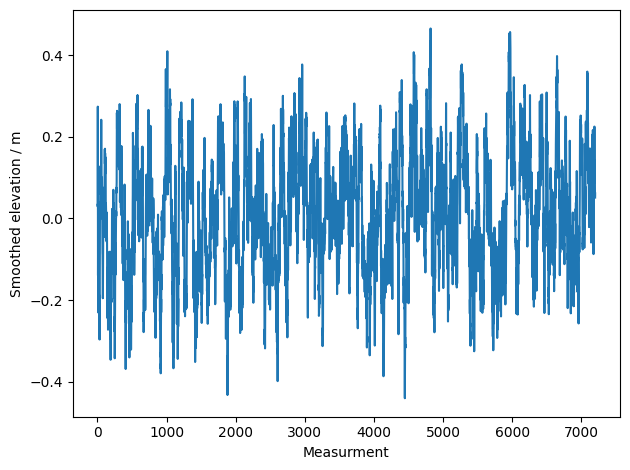

In [23]:
smoothed.plot()
pl.xlabel('Measurment')
pl.ylabel('Smoothed elevation / m')
pl.tight_layout()
pl.savefig('docs/images/experiment-smoothed.svg')

You can see that now it is much smoother, fluctuating only between -0.4 and +0.4 m.

In [25]:
diff = np.diff(smoothed.dropna())
diff[diff < 0] = 0
cumsum = np.cumsum(diff)

df = pd.DataFrame(enumerate(cumsum), columns=["index", "cumsum"])

In [26]:
(alt.Chart(df).mark_line().encode(alt.X("index", title='Measurement'), alt.Y("cumsum", title="Cumulative smoothed elevation gain / m")))

alt.Chart(...)

But when we compute the altitude gain, we still accumulate like 120 m over the two hours.

# Applying it to the mountainbike tour

We can see how it looks like for the mountainbike tour:

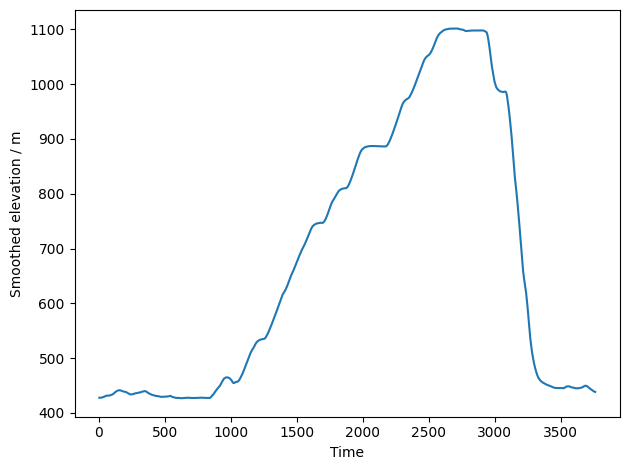

In [27]:
ts["altitude"].ewm(span=50, min_periods=5).mean().plot()
pl.xlabel('Time')
pl.ylabel('Smoothed elevation / m')
pl.tight_layout()
pl.savefig('docs/images/elevation-smoothed.svg')

But is `span=50` a good value? Are those ups and downs really there or are they just noise? Should we rather use `span=100` instead to make it even smoother?

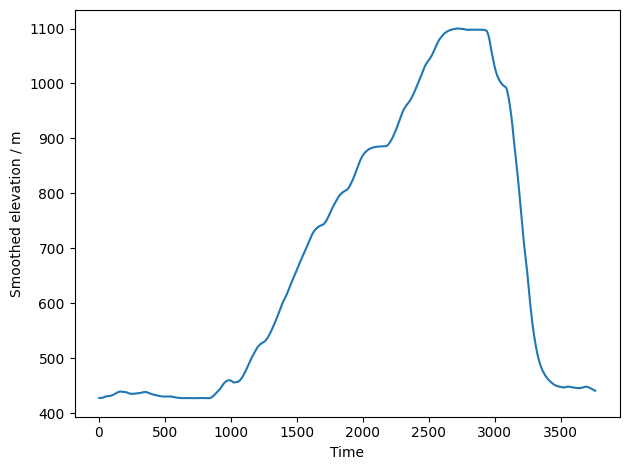

In [28]:
ts["altitude"].ewm(span=100, min_periods=5).mean().plot()
pl.xlabel('Time')
pl.ylabel('Smoothed elevation / m')
pl.tight_layout()
pl.savefig('docs/images/elevation-smoothed-100.svg')

Using `span=1000` is clearly too much smoothing:

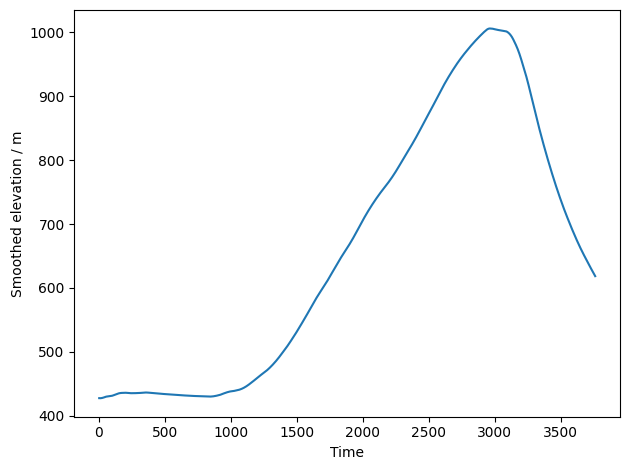

In [29]:
ts["altitude"].ewm(span=1000, min_periods=5).mean().plot()
pl.xlabel('Time')
pl.ylabel('Smoothed elevation / m')
pl.tight_layout()
pl.savefig('docs/images/elevation-smoothed-1000.svg')

We can go through various `span` values and see how much smoothing gets how much altitude gain.

In [30]:
scan = {"span": [], "gain": []}
for span in np.linspace(5, 1000, 100):
    diff = ts["altitude"].ewm(span=span, min_periods=5).mean().diff().dropna()
    diff[diff < 0] = 0
    cum = diff.sum()
    scan["span"].append(span)
    scan["gain"].append(cum)

(alt.Chart(pd.DataFrame(scan)).mark_line().encode(alt.X("span", title="Span value"), alt.Y("gain", title='Total elevation gain / m')))

alt.Chart(...)

And here we see that without smoothing there is around 1,400 m of altitude gain. But that feels too much. Increasing the smoothing we end up at around 610 m as estimated in the beginning. Likely it should be a bit more. Increasing the smoothing will eventually smooth out all the mountains, such that this curve will eventually converge to 0. Which is clearly wrong as well.

We would need to pick some value which feels somewhat right. But it would not be as objective as distance or time would be. By choosing the `span` value one can determine how much elevation gain there is.

Strava very likely uses the actual elevation data from maps to correct this. This is the superior method because elevation data is very noisy by default. But in Geo Activity Playground we don't have the actual map at this point and hence we cannot do this.